<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "IT-L5"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/IT-L5/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


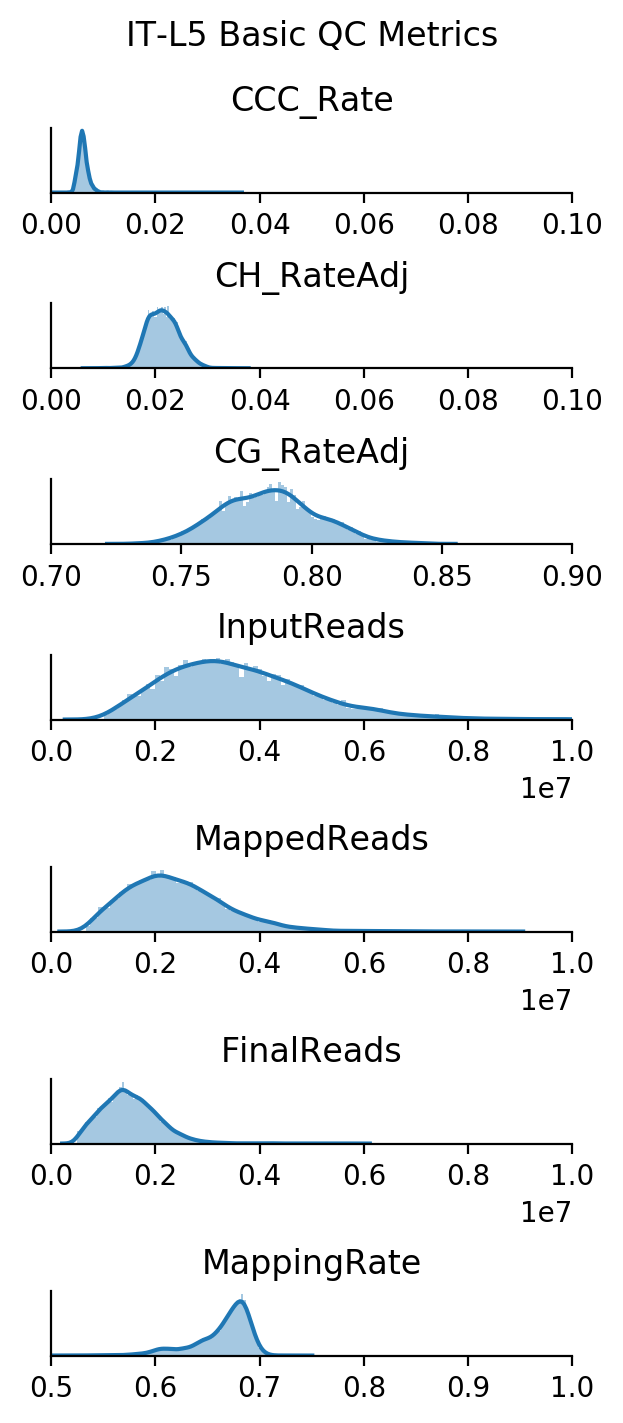

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

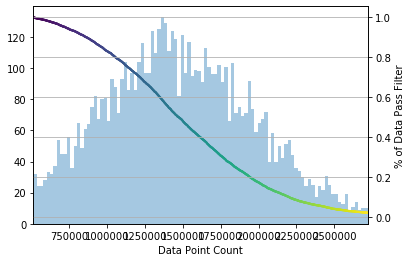

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 6640/6640 (100.0%)
CG_RateAdj passed 6640/6640 (100.0%)
CH_RateAdj passed 6640/6640 (100.0%)
FinalReads passed 6640/6640 (100.0%)
MappingRate passed 6640/6640 (100.0%)
Overall passed 6640/6640 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 167
171207 125
171212 42
171213 161
180104 175
180109 2
180110 1
180119 199
180122 166
180123 232
180129 218
180130 162
180205 179
180206 181
180208 4
180213 214
180220 10
180222 5
180226 255
180227 215
180305 160
180306 236
180312 188
180320 15
180326 14
180329 3
180402 1
180403 1
180409 195
180410 160
180412 168
180416 202
180417 75
180419 82
180423 101
180424 90
180426 140
180430 115
180501 156
180514 53
180529 80
180605 177
180612 185
180917 1
181002 69
181009 5
181022 117
181023 125
181210 74
190108 233
190117 209
190122 87
190124 71
190131 4
190205 181
190214 4
190307 149
190625 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 769 200.3%
ad002 837 218.0%
ad004 845 220.1%
ad006 804 209.4%
ad007 844 219.8%
ad008 867 225.8%
ad010 844 219.8%
ad012 830 216.1%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1278,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006996,0.757424,0.755715,0.031042,0.024215,2314675.0,6686084,4610594.0,10E,...,-11.380492,-28.949594,-12.534881,-11.456695,IT-L5,8.961619,-10.417772,19.368273,40.382910,True
11E_M_138,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006802,0.762939,0.761316,0.031105,0.024470,2067849.0,5601876,3783457.0,11E,...,-11.517125,-28.763699,-12.693058,-11.479976,IT-L5,8.611369,-10.128137,19.417128,40.316948,True
11E_M_371,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006012,0.806043,0.804869,0.026772,0.020886,1235000.0,2711380,1866286.0,11E,...,-9.905107,-28.981476,-17.050571,-9.868520,IT-L5,10.880786,-10.879870,23.024984,33.552198,True
11E_M_578,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006461,0.794095,0.792756,0.030125,0.023819,2141966.0,5098150,3420526.0,11E,...,-11.290858,-28.595972,-13.210736,-11.434197,IT-L5,8.869958,-9.939795,19.729579,39.995988,True
11E_M_783,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.005549,0.802455,0.801352,0.024056,0.018611,1050642.0,2302708,1568389.0,11E,...,-8.643709,-29.808352,-18.703279,-7.309232,IT-L5,12.064411,-10.892835,30.236091,22.109919,True
1A_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004300,0.778420,0.777460,0.021090,0.016860,958205.0,2123406,1421453.0,1A,...,-13.220352,-29.411230,-15.940890,-17.953816,IT-L5,7.072093,-12.372558,1.988413,17.187209,True
1A_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004990,0.780070,0.778970,0.025500,0.020610,1129187.0,2383058,1609106.0,1A,...,-7.406981,-29.082216,-24.881216,-6.224919,IT-L5,13.535682,-9.961327,28.746762,8.192716,True
1A_M_1007,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004790,0.762410,0.761270,0.024830,0.020140,1263817.0,2710876,1843183.0,1A,...,-11.529241,-29.886477,-10.656613,-13.821631,IT-L5,9.164296,-12.985395,8.017265,11.648001,True
1A_M_1028,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004420,0.775240,0.774240,0.022490,0.018150,1314298.0,2866602,1965274.0,1A,...,-12.983447,-30.031895,-10.482581,-16.402148,IT-L5,7.246218,-12.711396,3.526995,10.538577,True
